# Ayudantía 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Pregunta 1

Suponga que $(I-E)$ es invertible, muestre que $$ \dfrac{||(I-E)^{-1}-I||}{||(I-E)^{-1}||}\leq||E||$$.  
Utilizando este resultado deduzca que $$\dfrac{ 1}{1+||E||}\leq||(I-E)^{-1}||$$  

Finalmente haga un rutina que muestre estas cotas numéricamente.

In [2]:
#Lazy functions. Podríamos reportar en una tabla!! ¿Cómo lo harían?

def cota_1(n, p):
    
    E = np.random.random(size=(n,n))/1000
    I = np.identity(n)
    I_E_inv = np.linalg.inv(I-E)
    
    norma_E = np.linalg.norm(E, ord=p)
    norma_I_E_I = np.linalg.norm(I_E_inv - I, ord=p)
    norma_I_E = np.linalg.norm(I_E_inv, ord=p)
    
    l_izq = norma_I_E_I/norma_I_E
    l_der = norma_E
    
    #print(f"lado_izquierdo: {l_izq:.3f}")
    #print(f"lado_derecho: {l_der:.3f}")
    #print(f"Se cumple? {l_izq <= l_der}")
    
    return l_izq, l_der

def cota_2(n, p):
    
    E = np.random.random(size=(n,n))/1000
    I = np.identity(n)
    I_E_inv = np.linalg.inv(I-E)
    
    norma_E = np.linalg.norm(E, ord=p)
    norma_I_E = np.linalg.norm(I_E_inv, ord=p)
    
    l_izq = 1/(1+norma_E)
    l_der = norma_I_E
    
    #print(f"lado_izquierdo: {l_izq:.3f}")
    #print(f"lado_derecho: {l_der:.3f}")
    #print(f"Se cumple? {l_izq <= l_der}")
    
    return l_izq, l_der


def rutina_2(n):
    
    normas = [1, 2, np.inf] #indices
    cota_1_izq, cota_1_der = [], []
    cota_2_izq, cota_2_der = [], []
    
    for p in normas:
        lic1, ldc1 = cota_1(n, p)
        lic2, ldc2 = cota_2(n, p)
        cota_1_izq.append(lic1)
        cota_1_der.append(ldc1)
        cota_2_izq.append(lic2)
        cota_2_der.append(ldc2)
        
    tabla = pd.DataFrame(data={"p":normas, 
                               "Cota 1 izq": cota_1_izq,
                               "Cota 1 der": cota_1_der,
                               "True?": np.array(cota_1_izq)<=np.array(cota_1_der),
                               "Cota 2 izq": cota_2_izq,
                               "Cota 2 der": cota_2_der,
                               "True_2?": np.array(cota_2_izq)<=np.array(cota_2_der)})
    return tabla

In [3]:
rutina_2(2)

[[0.00080589 0.00066725]
 [0.0006761  0.00080358]]
[[0.00055138 0.00061933]
 [0.00046882 0.00011007]]
[[0.00077003 0.00017136]
 [0.00072084 0.00054459]]


,p,Cota 1 izq,Cota 1 der,True?,Cota 2 izq,Cota 2 der,True_2?
0,1.0,0.001272,0.001272,True,0.998520,1.001484,True
1,2.0,0.001063,0.001064,True,0.999075,1.000919,True
2,inf,0.001142,0.001142,True,0.998736,1.001267,True


# Pregunta 2

<b>Estabilidad:</b>

Un algoritmo $\tilde{f}$ es estable para un problema $f$ si:

$$\frac{\|f(\tilde{x})-\tilde{f}(x)\|}{\|f(\tilde{x})\|}=\mathcal{O}(\varepsilon_{M})$$

para algún $\tilde{x}$ tal que:

$$\frac{\|x-\tilde{x}\|}{\|x\|}=\mathcal{O}(\varepsilon_{M})$$

Estudiaremos la estabilidad de la eliminación Gaussiana con pivoteo parcial. Para esto, veremos el siguiente teorema (no demostraremos):

<b>Teorema:</b> 

Sea la factorización $PA=LU$ de $A\in \mathbb{C}^{m\times m}$, computada por algún algoritmo de eliminación Gaussiana con pivoteo parcial. Entonces, las matrices computadas $\tilde{P}, \tilde{L}, \tilde{U}$ cumplen lo siguiente:

$$ \tilde{L}\tilde{U} = \tilde{P}A + \delta A,\quad \frac{\|\delta A\|}{\|A\|}\in \mathcal{O}(\rho\varepsilon_{M})$$

donde $\rho$ es el factor de crecimiento definido por:

$$\rho = \frac{\max |u_{ij}|}{\max |a_{ij}|}$$

Si $\rho \in \mathcal{O}(1)$, entonces eliminación gaussiana con pivoteo parcial es backward-stable (recuerdos de la clase).


Qué mide $\rho$? En pocas palabras, mide cuanta información está almacenada en $U$ al reducir $A$ en dos matrices $L$, $U$. ¿Por qué no con L?

### Importamos los códigos de eliminación gaussiana de las clases:

In [4]:
def GEPP(A, b):
    '''
    Gaussian elimination with partial (row) pivoting
    input : A nonsingular and square matrix n x n 
            b vector n x 1
    output : x solution of the system A x = b
    '''
    # 1. Factorize A = PLU
    L, U, pT = LUPP(A)
    # 2. Solve P L U x = b
    Ptb = b[pT]
    # 3. Solve LUx = Pt b forward substitution
    y = forward_substitution(L, Ptb)
    # 4. Solve Ux = L^{-1} Pt b backward substitution
    x = backward_substitution(U,y)
    return x

def LUPP(Ainput):
    '''
    LU factorization with partial pivoting
    '''
    A = Ainput.copy()
    n = A.shape[0]
    pT = np.arange(0,n)
    for i in range(n-1):
        imax = abs(A[i:,i]).argmax() + i
        pT[[i,imax]] = pT[[imax,i]]
        if A[imax, i] == 0:
            raise ValueError("Matrix is singular.")
        elif imax != i:
            A[[i,imax],:] = A[[imax, i],:][:]
        A[(i+1):n,i][:] = (A[(i+1):n,i]/A[i,i])[:]
        A[(i+1):n, (i+1):n][:] = A[(i+1):n, (i+1):n]-np.outer(A[(i+1):n,i],A[i, (i+1):n])
    
    L = np.tril(A,-1)+np.eye(n)
    U = np.triu(A)
    return L, U, pT

def forward_substitution(L,b):
    '''
    Forward substitution algorithm for system L x = b
    input : L lower triangular matrix n x n
            b vector n x 1
    output: x solution of L x = b
    '''
    n = L.shape[0]
    x = np.zeros(n)
    x[0] = b[0]/L[0,0]
    for i in range(1,n):
        x[i] = (b[i] - L[i,0:i]@x[0:i])/L[i,i]
    return x

def backward_substitution(U,b):
    '''
    Backward substitution algorithm for system U x = b
    input : U upper tringular matrix n x n
            b vector n x 1
    output : x solution of U x = b
    '''
    n = U.shape[0]
    x = np.zeros(n)
    x[n-1] = b[n-1]/U[n-1,n-1]
    for i in range(n-2,-1,-1):
        x[i] = (b[i] - U[i,(i+1):n]@(x[(i+1):n]))/U[i,i]
    return x

### Creamos la función que calcula el factor de crecimiento:

In [5]:
def growth_factor(A):
    L, U, pT = LUPP(A)
    num = np.max(abs(U))
    den = np.max(abs(A))
    return num/den

Como dijimos antes, este valor en esencia nos dice que tanta información tiene $U$ con respecto a $A$. A mayor valor de $\rho$, mayor es la cantidad de información almacenada en ella. Vemos un ejemplo de esto:

### Ejemplo catastrófico para eliminación gaussiana

Consideramos la matriz:

$$A = 
\begin{bmatrix}
1&0&0&0&1\\
-1&1&0&0&1\\
-1&-1&1&0&1\\
-1&-1&-1&1&1\\
-1&-1&-1&-1&1
\end{bmatrix}$$

In [6]:
A = np.array([[1,0,0,0,1],
              [-1,1,0,0,1],
              [-1,-1,1,0,1],
              [-1,-1,-1,1,1],
              [-1,-1,-1,-1,1]]) # Matriz con mal factor de crecimiento

L, U, PT = LUPP(A)
print(U)

[[ 1  0  0  0  1]
 [ 0  1  0  0  2]
 [ 0  0  1  0  4]
 [ 0  0  0  1  8]
 [ 0  0  0  0 16]]


In [7]:
print(L)

[[ 1.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.]
 [-1. -1.  1.  0.  0.]
 [-1. -1. -1.  1.  0.]
 [-1. -1. -1. -1.  1.]]


In [8]:
print(growth_factor(A))

16.0


En particular, una matriz de la misma estructura de $A$ de $m\times m$ tiene un factor de crecimiento de $2^{m-1}$. Es decir, a problemas de mayor dimensión, eliminación gaussiana con pivoteo parcial comienza a ser altamente inestable por las entradas de $U$.

Un factor de crecimiento de $2^{m}$, corresponde a una pérdida de $\mathcal{O}(m)$ cifras significativas! Con una matriz de dimensión suficientemente baja ($m<100$) se puede perder mucha información!


Ahora, <b>¿Qué tan común es encontrar matrices para las cuales eliminación gaussiana sin pivoteo es inestable?</b>


Veremos que dentro de matrices generadas aleatoriamente a partir de cierta distribución, es raro encontrar factores de crecimiento $\rho$ elevados. Para esto, generaremos:

```python 3
for m=1,...,10,20,30,...,100,200,300,...,1000:
    rho_list = []
    for n=1,...,50:
        A = random_matrix((m, m), media=0, desv_standard=m^{-1/2})
        rho = growth_factor(A)
        rho_list.append(rho)
    plot(m, rho_list)
```

Así, veremos que los factores de crecimiento no se disparan más alla de la recta $y = \sqrt{m}$, a pesar de ser cada vez más cercana a una matriz llena de 0's cuando $m\to\infty$.

In [9]:
m_list = np.append(np.append(np.arange(1,11), np.arange(20, 101, 10)), np.arange(200, 1001, 100))
print(m_list)

[   1    2    3    4    5    6    7    8    9   10   20   30   40   50
   60   70   80   90  100  200  300  400  500  600  700  800  900 1000]


In [10]:
def growth_factor_list(m_list):
    """
    Dada una lista de valores m genera una matriz
    de mxm con valores extraidos de una normal de media
    0 y std. dev. sqrt(m)
    """
    List_rho_list = []
    
    for m in m_list:
        
        rho_list = []
        
        for n in range(50):
            
            A = np.random.normal(loc=0.0, scale=1/np.sqrt(m), size=(m, m))
            rho = growth_factor(A)
            rho_list.append(rho)
        
        List_rho_list.append(rho_list)
    
    return List_rho_list

In [11]:
def create_plot_lists(m_list):
    
    List = np.array(growth_factor_list(m_list))
    m, n = List.shape
    List = List.reshape(m*n)
    
    new_m_list = []
    for m in m_list:
        for i in range(n):
            new_m_list.append(m)
    
    return new_m_list, List

In [12]:
m_list_new, rho_list = create_plot_lists(m_list)

#### Revisamos el gráfico:

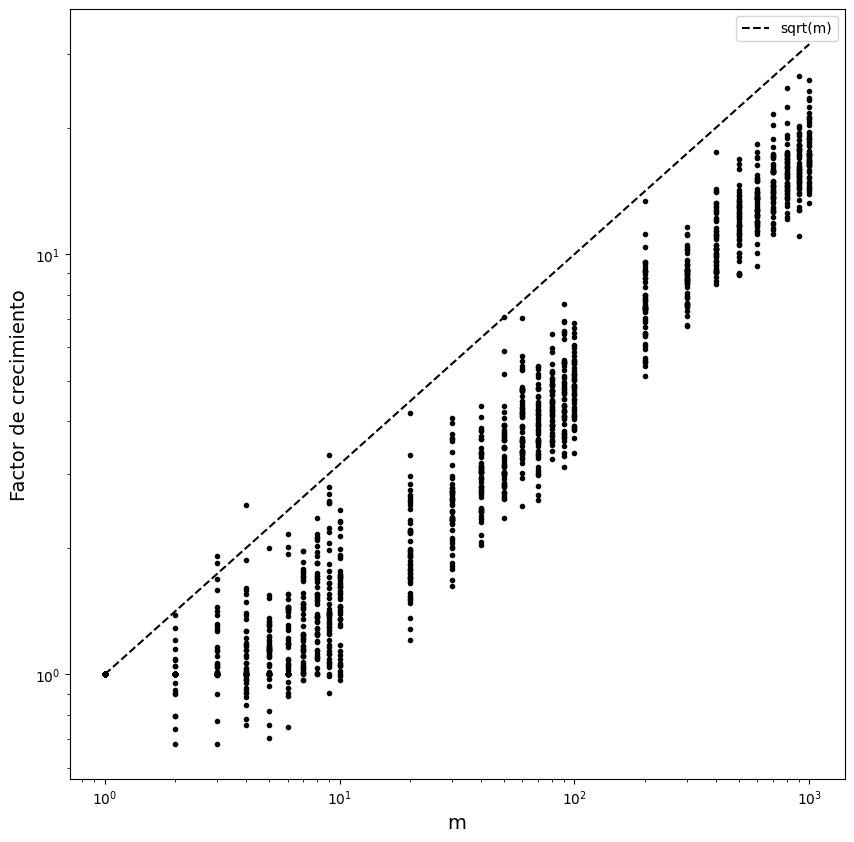

In [13]:
x = np.linspace(1,1000)

plt.figure(figsize=(10,10))

plt.scatter(m_list_new, rho_list, color="black", marker=".")
plt.plot(x, np.sqrt(x), "--k", label="sqrt(m)")
plt.xlabel("m", fontsize=14)
plt.ylabel("Factor de crecimiento", fontsize=14)
plt.legend(loc="best")
plt.yscale("log")
plt.xscale("log")
plt.show()

Vemos que los factores de crecimiento para este tipo de matrices está, generalmente, en el orden de $\sqrt{m}<<2^{m-1}$. Esto nos dice que, si bien podemos sacar muchas matrices random, por lo general es dificil encontrar una para la cual eliminación gaussiana es inestable.

En este ejemplo, se tomaron: $27\cdot 50=1350$ matrices. Un ejemplo más completo se puede hacer con 10 matrices por cada $n=1,\dots,1000$, tomando en total $10000$ matrices y obtendríamos los mismos resultados.

#### Para un $m$ fijo, podemos ver la distribución de densidad de estos factores de crecimiento.

Veremos esto para $m=8,16,32$, tomando 10000 matrices para cada $m$.

In [14]:
def rho_density_list(m, N=10000):
    
    rho_list = []
    
    for n in range(N):
        A = np.random.normal(loc=0.0, scale=1/np.sqrt(m), size=(m, m))
        rho = growth_factor(A)
        rho_list.append(rho)
    
    return rho_list

rho_8 = rho_density_list(8)
rho_16 = rho_density_list(16)
rho_32 = rho_density_list(32)

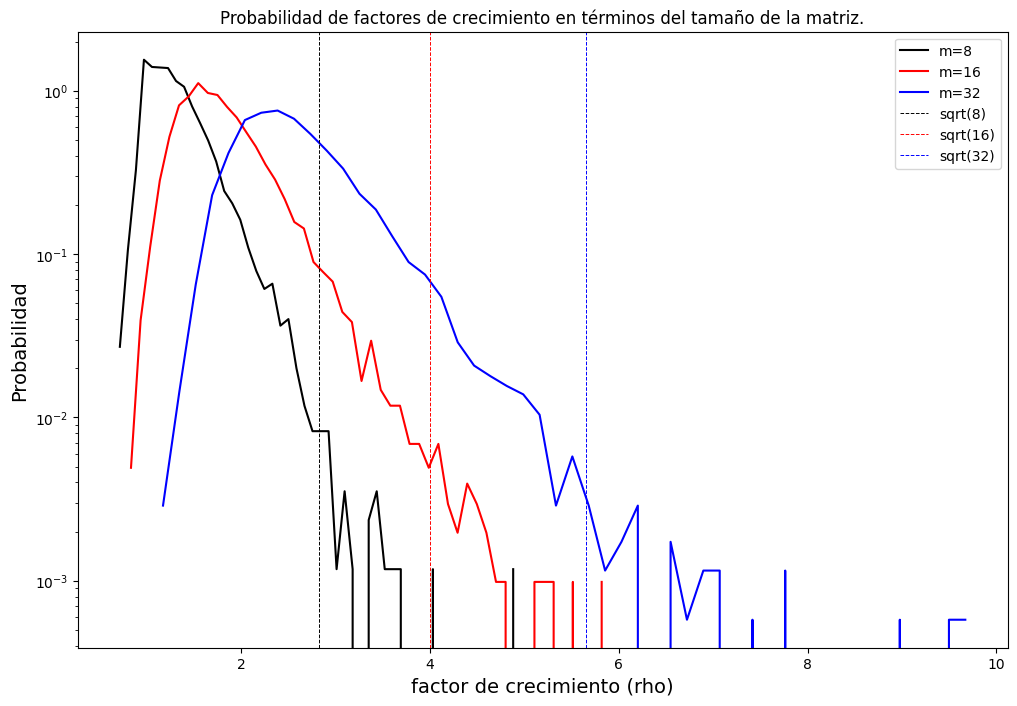

In [15]:
hist8, bin_edges8 = np.histogram(rho_8, bins=50, density=True)
hist16, bin_edges16 = np.histogram(rho_16, bins=50, density=True)
hist32, bin_edges32 = np.histogram(rho_32, bins=50, density=True)

plt.figure(figsize=(12,8))

#density histogram
plt.plot(bin_edges8[:-1], hist8, 'k-', label="m=8")
plt.plot(bin_edges16[:-1], hist16, 'r-', label="m=16")
plt.plot(bin_edges32[:-1], hist32, 'b-', label="m=32")

#Vertical lines
plt.axvline(x=np.sqrt(8), color="k", linewidth=0.7, linestyle="--", label="sqrt(8)")
plt.axvline(x=np.sqrt(16), color="red", linewidth=0.7, linestyle="--", label="sqrt(16)")
plt.axvline(x=np.sqrt(32), color="blue", linewidth=0.7, linestyle="--", label="sqrt(32)")

plt.title("Probabilidad de factores de crecimiento en términos del tamaño de la matriz.")
plt.xlabel("factor de crecimiento (rho)", fontsize=14)
plt.ylabel("Probabilidad", fontsize=14)
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

## Tutorial matrices sparse

¿Por qué usarlas?

Memoria limitada! Si no toda la matriz tiene información (0's), es realmente valioso almacenarla completa?

In [16]:
import scipy.sparse as sps
import scipy.sparse.linalg as LA

### (CSC) Compressed Sparse Column:


Tomamos 3 listas:

- row: índices de la filas
- col: índices de las columnas. Debe ir ordenado de menor a mayor.
- data: datos ordenados por (filas,columnas)

Para esto, se ordena primero col, y después row. Por ejemplo, la matriz:

$$A = 
\begin{pmatrix}
1&&&&1\\
&1&&&2\\
&&1&&4\\
&&&1&8\\
&&&&16
\end{pmatrix}$$

Tendría:

``` python 3
col = [0, 1, 2, 3, 4, 4, 4, 4, 4]
row = [0, 1, 2, 3, 0, 1, 2, 3, 4]
data = [1, 1, 1, 1, 1, 2, 4, 8, 16]
```

In [33]:
col = [0, 1, 2, 3, 4, 4, 4, 4, 4]
row = [0, 1, 2, 3, 0, 1, 2, 3, 4]
data = [1, 1, 1, 1, 1, 2, 4, 8, 16]

A_sparse = sps.csc_matrix((data, (row, col)), shape=(5, 5))

#Esta es la matriz vista como array
print(A_sparse.toarray())
print("")

#Esto se está almacenando en memoria
print(A_sparse)

[[ 1  0  0  0  1]
 [ 0  1  0  0  2]
 [ 0  0  1  0  4]
 [ 0  0  0  1  8]
 [ 0  0  0  0 16]]

  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (0, 4)	1
  (1, 4)	2
  (2, 4)	4
  (3, 4)	8
  (4, 4)	16


### (CSR) Compressed Sparse Row:

Similar a CSC, pero ordenamos primero la lista de fila y la de columnas después. Para el ejemplo anterior se tiene:

$$A = 
\begin{pmatrix}
1&&&&1\\
&1&&&2\\
&&1&&4\\
&&&1&8\\
&&&&16
\end{pmatrix}$$

Tendría:

``` python 3
row = [0, 0, 1, 1, 2, 2, 3, 3, 4]
col = [0, 4, 1, 4, 2, 4, 3, 4, 4]
data = [1, 1, 1, 2, 1, 4, 1, 8, 16]
```

In [18]:
row = [0, 0, 1, 1, 2, 2, 3, 3, 4]
col = [0, 4, 1, 4, 2, 4, 3, 4, 4]
data = [1, 1, 1, 2, 1, 4, 1, 8, 16]

A_sparse = sps.csr_matrix((data, (row, col)), shape=(5, 5))

#Esta es la matriz vista como array
print(A_sparse.toarray())
print("")

#Es rápido hacer slices por fila. Por columna es más rápido hacerlo con CSC.
print(A_sparse[:3,:])

[[ 1  0  0  0  1]
 [ 0  1  0  0  2]
 [ 0  0  1  0  4]
 [ 0  0  0  1  8]
 [ 0  0  0  0 16]]

  (0, 0)	1
  (0, 4)	1
  (1, 1)	1
  (1, 4)	2
  (2, 2)	1
  (2, 4)	4


### (COO)rdinate format

Este pide las mismas 3 listas, pero aquí podemos darlas en otro orden. En row se entrega el índice asociado a la fila, en col la columna que corresponde y en data el valor que se AÑADE a la matriz.

AÑADE = SUMA en este caso. Por ejemplo, para la misma matriz

$$A = 
\begin{pmatrix}
1&&&&1\\
&1&&&2\\
&&1&&4\\
&&&1&8\\
&&&&16
\end{pmatrix}$$

una forma de definirla es como:

``` python 3
row = [0, 1, 2, 3, 4, 0, 1, 2, 3] #primero la diagonal y luego el resto
col = [0, 1, 2, 3, 4, 4, 4, 4, 4] #primero la diagonal y luego el resto
data = [1, 1, 1, 1, 16, 1, 2, 4, 8]
```

Mientras que otra puede ser la de otros formatos, modificadas (CSR en el ejemplo, y separando la última coordenada):

``` python 3
row = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 4]
col = [0, 4, 1, 4, 2, 4, 3, 4, 4, 4, 4, 4]
data = [1, 1, 1, 2, 1, 4, 1, 8, 4, 4, 4, 4]
```

Aquí separamos la última entrada en 4: $4+4+4+4=16$

In [34]:
row = [0, 1, 2, 3, 4, 0, 1, 2, 3] #primero la diagonal y luego el resto
col = [0, 1, 2, 3, 4, 4, 4, 4, 4] #primero la diagonal y luego el resto
data = [1, 1, 1, 1, 16, 1, 2, 4, 8]

A_sparse = sps.coo_matrix((data, (row, col)), shape=(5, 5))

#Esta es la matriz vista como array
print(A_sparse.toarray())
print(A_sparse)

[[ 1  0  0  0  1]
 [ 0  1  0  0  2]
 [ 0  0  1  0  4]
 [ 0  0  0  1  8]
 [ 0  0  0  0 16]]
  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (4, 4)	16
  (0, 4)	1
  (1, 4)	2
  (2, 4)	4
  (3, 4)	8


In [20]:
row = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 4]
col = [0, 4, 1, 4, 2, 4, 3, 4, 4, 4, 4, 4]
data = [1, 1, 1, 2, 1, 4, 1, 8, 4, 4, 4, 4]

A_sparse = sps.coo_matrix((data, (row, col)), shape=(5, 5))

#Esta es la matriz vista como array
print(A_sparse.toarray())

[[ 1  0  0  0  1]
 [ 0  1  0  0  2]
 [ 0  0  1  0  4]
 [ 0  0  0  1  8]
 [ 0  0  0  0 16]]


Hay más formatos, pero estos son 3 de los más útiles (IMO).


Veamos como resolver un sistema con matrices sparse:

Pensemos en resolver mediante diferencias finitas:

$$\begin{cases}-u''(x) = 4\pi^2\sin(2\pi x),& x\in(0,1)\\
u(x) = 0,& x\in\{0,1\}
\end{cases}$$

Esto nos da la matriz tridiagonal$(-1,2,-1)$ de $N\times N$ si $(0,1)$ está discretizado por $N$ puntos.

In [21]:
N = 10000
x = np.linspace(0, 1, num=N+2)
h = 1/(N+1)

f = lambda x: 4*(np.pi**2)*np.sin(2*np.pi*x)
b = h*h*f(x[1:-1])

In [22]:
def Assemble_FD_matrix(N):
    row = []
    col = []
    data = []
    for i in range(N): #Recorro por filas
        
        #Agrego diagonal
        row.append(i)
        col.append(i)
        data.append(2)
        
        #Agrego derecho si i<N-1
        if i<N-1:
            row.append(i)
            col.append(i+1)
            data.append(-1)
        
        #Agrego izquierda si i>0
        if i>0:
            row.append(i)
            col.append(i-1)
            data.append(-1)
            
    A_sparse = sps.csr_matrix((data, (row, col)), shape=(N, N))
    return A_sparse

In [23]:
## Assemble using diags 
def Assemble_FD_matrix_diags(N):
    diags = sps.diags([-1, 2, -1], [-1, 0, 1], shape=(N, N))
    return diags

### Resolvemos el sistema:

In [36]:
#Sanity check: Armé la matriz?
A = Assemble_FD_matrix_diags(10)
print(A.toarray())

[[ 2. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  2.]]


In [37]:
import time
print(N)

10000


In [39]:
 times_a_mano = [] 
 times_diags = []
 for i in range(100):   
    t1 = time.time()
    A = Assemble_FD_matrix_diags(N)
    t2 = time.time()
    A2 = Assemble_FD_matrix(N)
    t3 = time.time()
    times_diags.append(t2-t1)
    times_a_mano.append(t3-t2)
    # print(f"Tiempo de ensamblaje diags: {t2-t1}")
    # print(f"Tiempo de ensamblaje a mano: {t3-t2}")

print(f"Tiempo de ensamblaje diags: {np.mean(times_diags)}")
print(f"Tiempo de ensamblaje a mano: {np.mean(times_a_mano)}")

Tiempo de ensamblaje diags: 6.964206695556641e-05
Tiempo de ensamblaje a mano: 0.006397261619567871


In [27]:
np.max(A-A2)

0.0

Lo siguiente es solo para mostrar que ensamblar de 2 maneras entrega el mismo resultado en sparse y el ensamble es independiente de la inversión de la matriz.

In [40]:
times_a_mano = [] 
times_diags = []
for i in range(100): 
    t1 = time.time()
    u2 = LA.spsolve(A2, b)
    t2 = time.time()
    u = LA.spsolve(A, b)
    t3 = time.time()
    times_diags.append(t2-t1)
    times_a_mano.append(t3-t2)


print(f"Tiempo de invertir matriz a mano: {np.mean(times_a_mano)}")
print(f"Tiempo de invertir matriz diags: {np.mean(times_diags)}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Tiempo de invertir matriz a mano: 0.0025289630889892578
Tiempo de invertir matriz diags: 0.0020879197120666506


In [41]:
t1 = time.time()
B = A.toarray()
t2 = time.time()
print(f"Tiempo de ensamblaje: {t2-t1}")

t1 = time.time()
u = np.linalg.solve(B, b)
t2 = time.time()

print(f"Tiempo de invertir matriz: {t2-t1}")

Tiempo de ensamblaje: 0.04717898368835449
Tiempo de invertir matriz: 3.5116260051727295


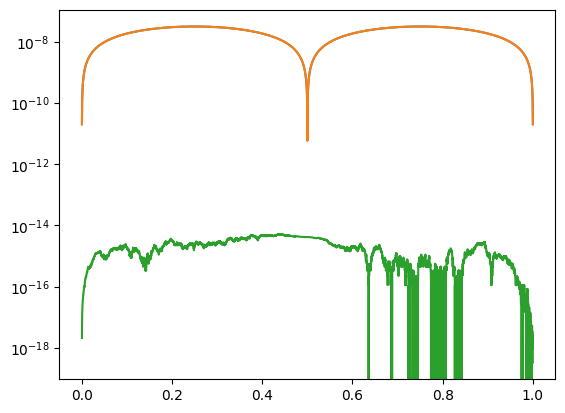

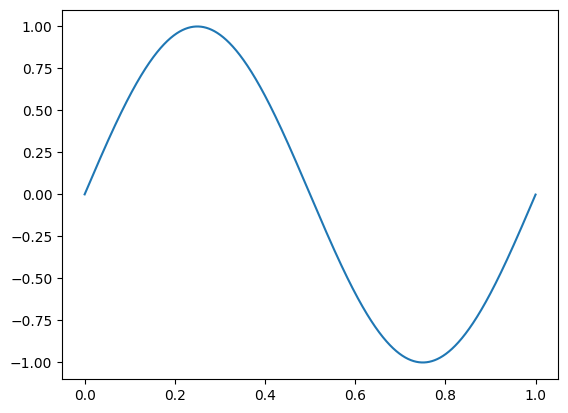

In [42]:
t = x[1:-1]
g = lambda x: np.sin(2*np.pi*x)

#plt.plot(t, u)
#plt.plot(t, g(t))
plt.plot(t, abs(g(t)-u2))
plt.plot(t,abs(g(t)-u))
plt.plot(t, abs(u2-u))
plt.yscale("log")

plt.show()
plt.clf()
plt.plot(t, u)

Kronecker es igual de rápido para sparse o para numpy?

i: 4, np: 157.25431871414185, sp: 0.27492403984069824
i: 8, np: 157.5296356678009, sp: 0.0006241798400878906
i: 16, np: 157.53031492233276, sp: 0.0007469654083251953
i: 32, np: 157.53110671043396, sp: 0.0006430149078369141
i: 64, np: 157.53178691864014, sp: 0.0010838508605957031
i: 128, np: 157.53293800354004, sp: 0.0024557113647460938
i: 256, np: 157.53544783592224, sp: 0.007927894592285156
i: 512, np: 157.54343485832214, sp: 0.03175783157348633


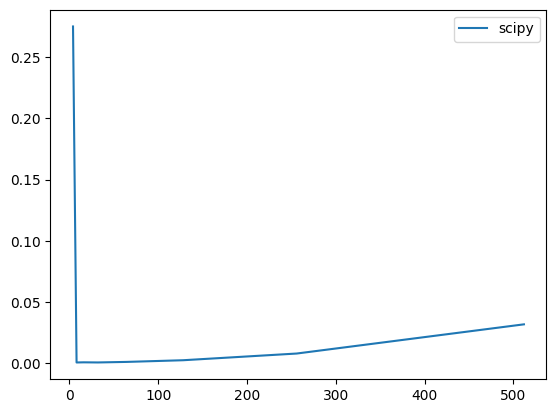

In [49]:
times_np = []
times_sp = []
for i in [2**i for i in range(2, 10)]:
    A1D = Assemble_FD_matrix_diags(i)
    # t1 = time.time()
    # A2D = np.kron(np.eye(i), A1D.toarray()) + np.kron( A1D.toarray(), np.eye(i))
    t2 = time.time()
    A2Dsp = sps.kron(sps.eye(i), A1D) + sps.kron(A1D, sps.eye(i))
    t3 = time.time()
    times_sp.append(t3-t2)
    print(f"i: {i}, np: {t2-t1}, sp: {t3-t2}")
    
    
# plt.plot([2**i for i in range(2, 8)], times_np, label="numpy")
plt.plot([2**i for i in range(2, 10)], times_sp, label="scipy")
plt.legend(loc="best")
plt.show()



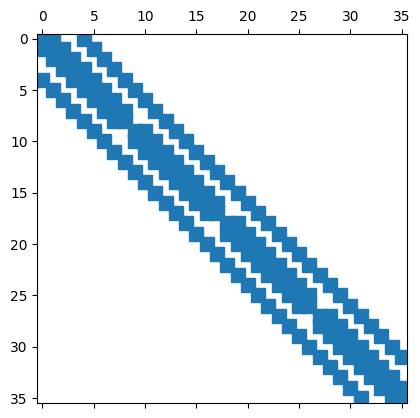

In [53]:
A1D = Assemble_FD_matrix_diags(9)
# t1 = time.time()
# A2D = np.kron(np.eye(i), A1D.toarray()) + np.kron( A1D.toarray(), np.eye(i))
t2 = time.time()
A2Dsp = sps.kron(sps.eye(4), A1D) + sps.kron(A1D, sps.eye(4))
plt.spy(A2Dsp)